<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

In [157]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [158]:
flotation = pd.read_csv('Flotation_Plant_Clean.csv')

##**4. Data Preprocessing**

###**4.1. Dataset information**

In [159]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


In [160]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          737453 non-null  object 
 1   iron_feed     737453 non-null  float64
 2   silica_feed   737453 non-null  float64
 3   starch_flow   737453 non-null  float64
 4   amina_flow    737453 non-null  float64
 5   pulp_flow     737453 non-null  float64
 6   pulp_pH       737453 non-null  float64
 7   pulp_density  737453 non-null  float64
 8   airflow_col1  736850 non-null  float64
 9   airflow_col2  736803 non-null  float64
 10  airflow_col3  736843 non-null  float64
 11  airflow_col4  737075 non-null  float64
 12  airflow_col5  737066 non-null  float64
 13  airflow_col6  736757 non-null  float64
 14  airflow_col7  736766 non-null  float64
 15  level_col1    736719 non-null  float64
 16  level_col2    736687 non-null  float64
 17  level_col3    736673 non-null  float64
 18  leve

### **4.2. Grouping Data points with hourly frequency**

I propose the inclusion of comprehensive plant data analysis by employing a loop-based methodology. This approach involves considering each individual row of data within a loop. The procedure consists of supplying the plant with 100 tons of ore, subjecting it to enrichment processes, and completing the cycle. Each cycle is denoted as one hour in this dataset. Consequently, a photograph of the plant is captured and analyzed every hour.

Theare are some dvantages and disadvantages of the grouping: Each analysis will be able to do each data cycle on an hourly frequency. The number of rows fell to 4097 from 737453. This is advantage for computer iteration. But less data points is disadvantage for  better results we get more accurate result with  machine learning techniques. This large data loss will adversely affect our estimation results.

In [161]:
flotation['date'] = pd.to_datetime(flotation['date'])
#grouping the data according to the hours and get their average values. 
flotation = flotation.groupby(pd.Grouper(key='date',freq='H')).mean()
flotation.reset_index(inplace = True)

In [162]:
#some rows have 'null' values because of timing. We need to drop them 
print('Shape of Grouped Flotation Data = ', flotation.shape)
flotation = flotation.dropna()
print('Shape of Grouped Flotation Data after drop null values = ', flotation.shape)

Shape of Grouped Flotation Data =  (4415, 24)
Shape of Grouped Flotation Data after drop null values =  (4097, 24)


In [163]:
flotation.drop(['date'], axis=1, inplace=True)

In [164]:
flotation.head().T

,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,16.980000,16.980000,16.980000,16.980000,16.980000
starch_flow,323.277098,313.325639,347.948294,334.142022,340.935100
amina_flow,578.786678,537.219661,591.906744,593.170106,619.710806
pulp_flow,398.753368,399.871822,398.763806,399.866983,399.615089
pulp_pH,10.113621,10.129944,10.048444,9.918389,9.745722
pulp_density,1.729598,1.667556,1.733000,1.730944,1.765889
airflow_col1,251.166672,249.880589,250.161328,250.208772,249.917800
airflow_col2,250.226086,250.214050,250.104167,250.204761,250.160494
airflow_col3,250.178287,250.033317,250.046350,250.120861,250.013500


In [165]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4097 entries, 0 to 4414
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iron_feed     4097 non-null   float64
 1   silica_feed   4097 non-null   float64
 2   starch_flow   4097 non-null   float64
 3   amina_flow    4097 non-null   float64
 4   pulp_flow     4097 non-null   float64
 5   pulp_pH       4097 non-null   float64
 6   pulp_density  4097 non-null   float64
 7   airflow_col1  4097 non-null   float64
 8   airflow_col2  4097 non-null   float64
 9   airflow_col3  4097 non-null   float64
 10  airflow_col4  4097 non-null   float64
 11  airflow_col5  4097 non-null   float64
 12  airflow_col6  4097 non-null   float64
 13  airflow_col7  4097 non-null   float64
 14  level_col1    4097 non-null   float64
 15  level_col2    4097 non-null   float64
 16  level_col3    4097 non-null   float64
 17  level_col4    4097 non-null   float64
 18  level_col5    4097 non-null 

###**4.3. Check Missing & Duplicated Values**

In [166]:
missing_values = flotation.isnull().sum()
print(missing_values)

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col1    0
airflow_col2    0
airflow_col3    0
airflow_col4    0
airflow_col5    0
airflow_col6    0
airflow_col7    0
level_col1      0
level_col2      0
level_col3      0
level_col4      0
level_col5      0
level_col6      0
level_col7      0
iron_conc       0
silica_conc     0
dtype: int64


- There is no missing values across the dataframe

In [167]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col1    0
airflow_col2    0
airflow_col3    0
airflow_col4    0
airflow_col5    0
airflow_col6    0
airflow_col7    0
level_col1      0
level_col2      0
level_col3      0
level_col4      0
level_col5      0
level_col6      0
level_col7      0
iron_conc       0
silica_conc     0
dtype: int64

- No duplicated values across the dataframe

###**4.4. Dataset summary statistics**

In [168]:
round(flotation.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
iron_feed,4097.0,56.29,5.16,42.74,52.67,56.08,59.72,65.78
silica_feed,4097.0,14.65,6.81,1.31,8.94,13.85,19.60,33.40
starch_flow,4097.0,338.10,92.69,102.57,283.59,335.44,382.47,963.31
amina_flow,4097.0,488.15,83.69,242.93,436.04,502.45,549.52,736.98
pulp_flow,4097.0,397.58,8.37,376.84,398.85,399.84,400.59,418.07
pulp_pH,4097.0,9.77,0.38,8.75,9.54,9.80,10.03,10.81
pulp_density,4097.0,1.68,0.06,1.52,1.65,1.70,1.72,1.83
airflow_col1,4097.0,280.15,29.41,175.89,250.09,299.84,299.95,312.30
airflow_col2,4097.0,277.16,29.42,178.19,250.10,299.53,299.98,309.89
airflow_col3,4097.0,281.08,28.37,177.20,250.09,299.89,299.95,302.78


In [169]:
flotation.head().T

,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,16.980000,16.980000,16.980000,16.980000,16.980000
starch_flow,323.277098,313.325639,347.948294,334.142022,340.935100
amina_flow,578.786678,537.219661,591.906744,593.170106,619.710806
pulp_flow,398.753368,399.871822,398.763806,399.866983,399.615089
pulp_pH,10.113621,10.129944,10.048444,9.918389,9.745722
pulp_density,1.729598,1.667556,1.733000,1.730944,1.765889
airflow_col1,251.166672,249.880589,250.161328,250.208772,249.917800
airflow_col2,250.226086,250.214050,250.104167,250.204761,250.160494
airflow_col3,250.178287,250.033317,250.046350,250.120861,250.013500


In [170]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4097 entries, 0 to 4414
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iron_feed     4097 non-null   float64
 1   silica_feed   4097 non-null   float64
 2   starch_flow   4097 non-null   float64
 3   amina_flow    4097 non-null   float64
 4   pulp_flow     4097 non-null   float64
 5   pulp_pH       4097 non-null   float64
 6   pulp_density  4097 non-null   float64
 7   airflow_col1  4097 non-null   float64
 8   airflow_col2  4097 non-null   float64
 9   airflow_col3  4097 non-null   float64
 10  airflow_col4  4097 non-null   float64
 11  airflow_col5  4097 non-null   float64
 12  airflow_col6  4097 non-null   float64
 13  airflow_col7  4097 non-null   float64
 14  level_col1    4097 non-null   float64
 15  level_col2    4097 non-null   float64
 16  level_col3    4097 non-null   float64
 17  level_col4    4097 non-null   float64
 18  level_col5    4097 non-null 

###**4.5. Corellation between the variables**

In [171]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col1,airflow_col2,airflow_col3,...,airflow_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,iron_conc,silica_conc
iron_feed,1.000000,-0.971833,-0.012559,-0.096103,0.186244,0.007577,-0.136240,-0.062833,-0.173629,-0.062609,...,-0.017229,0.031642,0.023024,0.016523,0.019308,0.026213,0.004420,0.030095,0.055453,-0.077114
silica_feed,-0.971833,1.000000,0.029043,0.085842,-0.174750,0.008251,0.113379,0.092424,0.187099,0.084742,...,0.047718,-0.041068,-0.040838,-0.024673,-0.040812,-0.049272,-0.023235,-0.054304,-0.044189,0.072782
starch_flow,-0.012559,0.029043,1.000000,0.039582,0.047521,0.229645,-0.118286,0.104585,0.113696,0.134843,...,0.139397,-0.199213,-0.167522,-0.137965,0.036975,0.043733,0.058323,0.015003,0.035215,-0.043415
amina_flow,-0.096103,0.085842,0.039582,1.000000,0.237537,0.134096,0.659796,0.121835,0.136783,0.111313,...,0.091204,-0.276352,-0.235733,-0.290044,-0.213534,-0.242772,-0.244882,-0.199846,-0.120195,0.170936
pulp_flow,0.186244,-0.174750,0.047521,0.237537,1.000000,0.138869,0.019719,-0.160489,-0.140432,-0.164065,...,-0.171307,-0.017101,-0.020164,-0.079609,-0.008492,0.005663,-0.023276,0.024781,0.096460,0.009666
pulp_pH,0.007577,0.008251,0.229645,0.134096,0.138869,1.000000,0.122491,0.168195,0.151999,0.199074,...,0.188252,-0.179822,-0.172842,-0.155013,0.057519,0.014010,-0.090097,0.022130,0.197945,-0.151512
pulp_density,-0.136240,0.113379,-0.118286,0.659796,0.019719,0.122491,1.000000,-0.006027,0.028342,-0.035002,...,-0.060547,-0.100760,-0.078643,-0.139880,-0.102055,-0.162453,-0.120874,-0.100637,0.017147,0.050520
airflow_col1,-0.062833,0.092424,0.104585,0.121835,-0.160489,0.168195,-0.006027,1.000000,0.866607,0.959985,...,0.678017,-0.476578,-0.472045,-0.406797,-0.074354,-0.103321,-0.141681,-0.128481,0.099352,-0.220865
airflow_col2,-0.173629,0.187099,0.113696,0.136783,-0.140432,0.151999,0.028342,0.866607,1.000000,0.879141,...,0.617642,-0.473857,-0.477412,-0.407483,-0.092169,-0.128343,-0.141768,-0.133970,0.060194,-0.171580
airflow_col3,-0.062609,0.084742,0.134843,0.111313,-0.164065,0.199074,-0.035002,0.959985,0.879141,1.000000,...,0.680858,-0.475392,-0.467462,-0.399069,-0.056453,-0.072653,-0.119464,-0.099606,0.100843,-0.220484


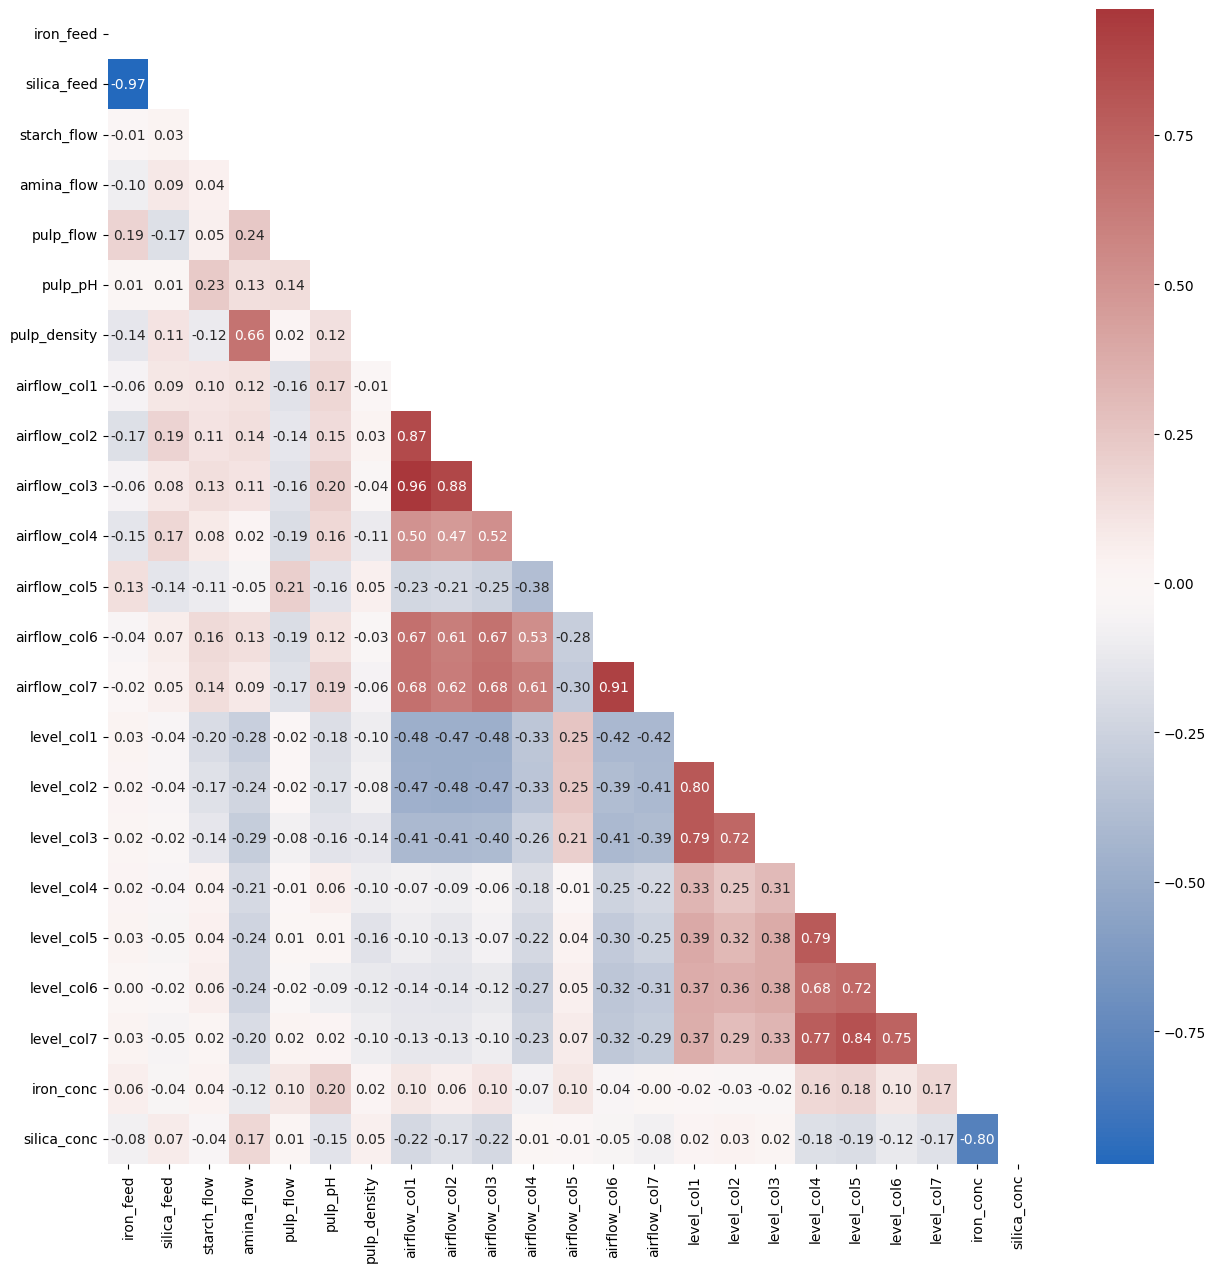

In [172]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()


In [173]:
correlation = flotation.corr().abs()
mask = correlation.mask(np.triu(np.ones(correlation.shape, dtype=bool)))
sorted_correlation = mask.unstack().sort_values(ascending=False)
sorted_correlation = sorted_correlation[(sorted_correlation > 0.65) & (sorted_correlation < 1.0)].reset_index()

# Rename the columns
sorted_correlation.columns = ['variable_1', 'variable_2', 'correlation_degree']

# Reorder the columns
sorted_correlation = sorted_correlation[['variable_1', 'variable_2', 'correlation_degree']]

# Print the resulting DataFrame
print(sorted_correlation)

      variable_1    variable_2  correlation_degree
0      iron_feed   silica_feed            0.971833
1   airflow_col1  airflow_col3            0.959985
2   airflow_col6  airflow_col7            0.910658
3   airflow_col2  airflow_col3            0.879141
4   airflow_col1  airflow_col2            0.866607
5     level_col5    level_col7            0.836032
6      iron_conc   silica_conc            0.801212
7     level_col1    level_col2            0.799330
8     level_col1    level_col3            0.794009
9     level_col4    level_col5            0.787744
10    level_col4    level_col7            0.772182
11    level_col6    level_col7            0.745292
12    level_col2    level_col3            0.723597
13    level_col5    level_col6            0.715789
14    level_col4    level_col6            0.683459
15  airflow_col3  airflow_col7            0.680858
16  airflow_col1  airflow_col7            0.678017
17  airflow_col1  airflow_col6            0.674750
18  airflow_col3  airflow_col6 

- Drop highly correlated columns

In [174]:
flotation.drop(['iron_feed', 'airflow_col1', 'airflow_col2', 'airflow_col7', 'level_col1', 
                'level_col4', 'level_col6', 'level_col6', 'iron_conc'], axis=1, inplace=True)

###**4.6. Check & remove outliers**

- Visualize the variables for seeing outliers

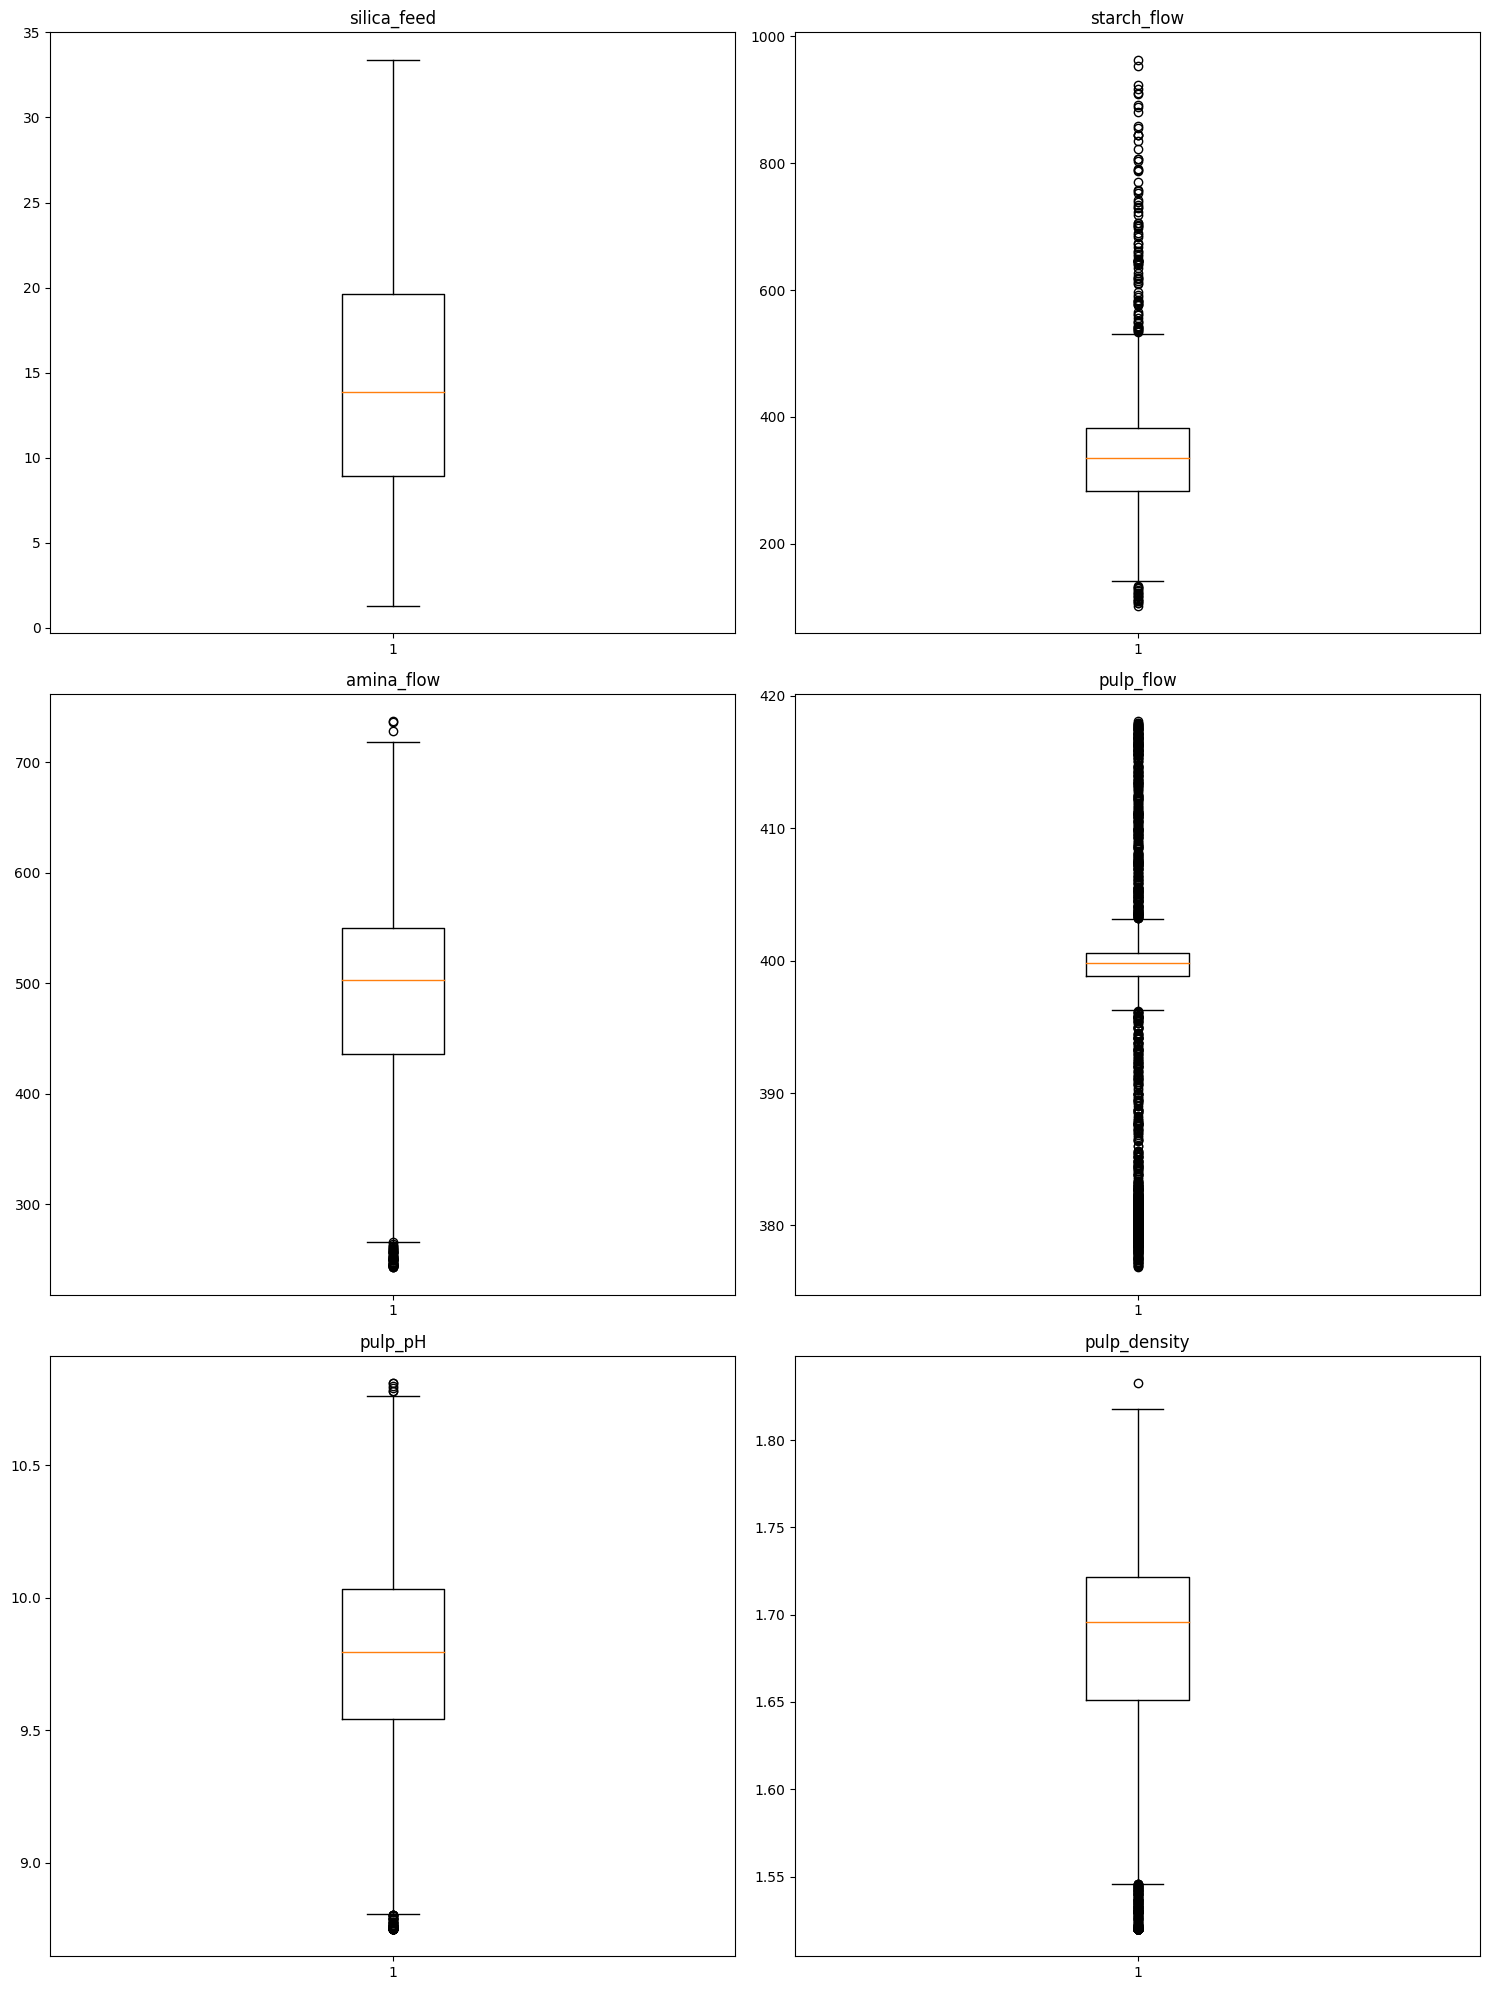

In [185]:
variables = ["silica_feed", "starch_flow", "amina_flow", 
             "pulp_flow", "pulp_pH", "pulp_density"]

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

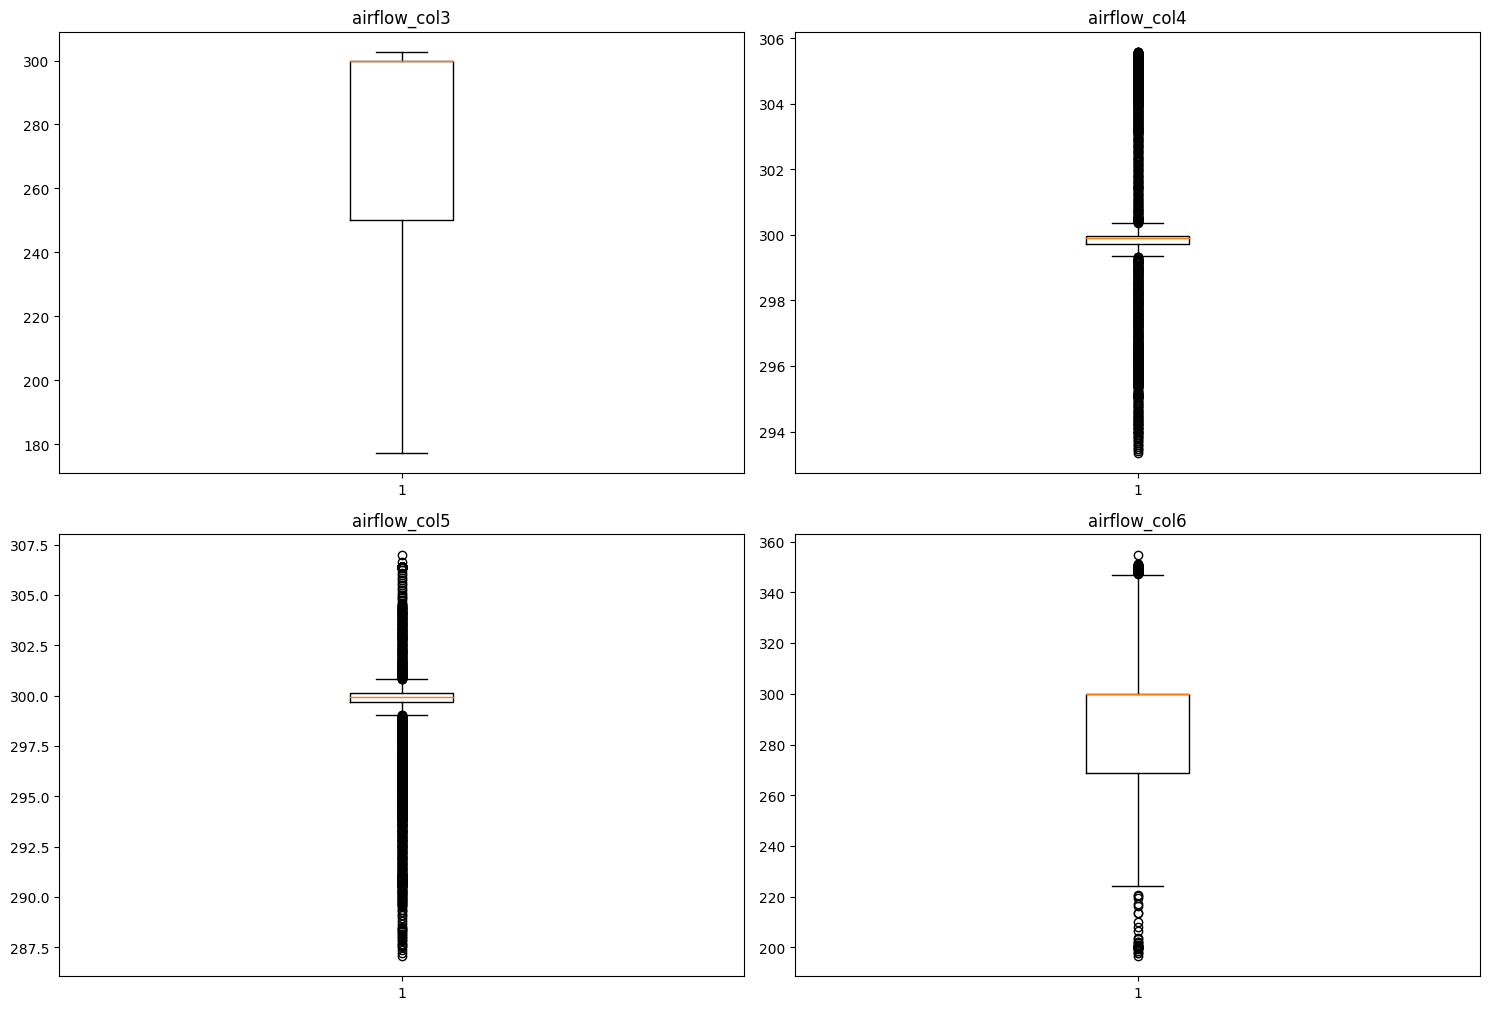

In [186]:
variables = ["airflow_col3", "airflow_col4", 
             "airflow_col5", "airflow_col6"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(3, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

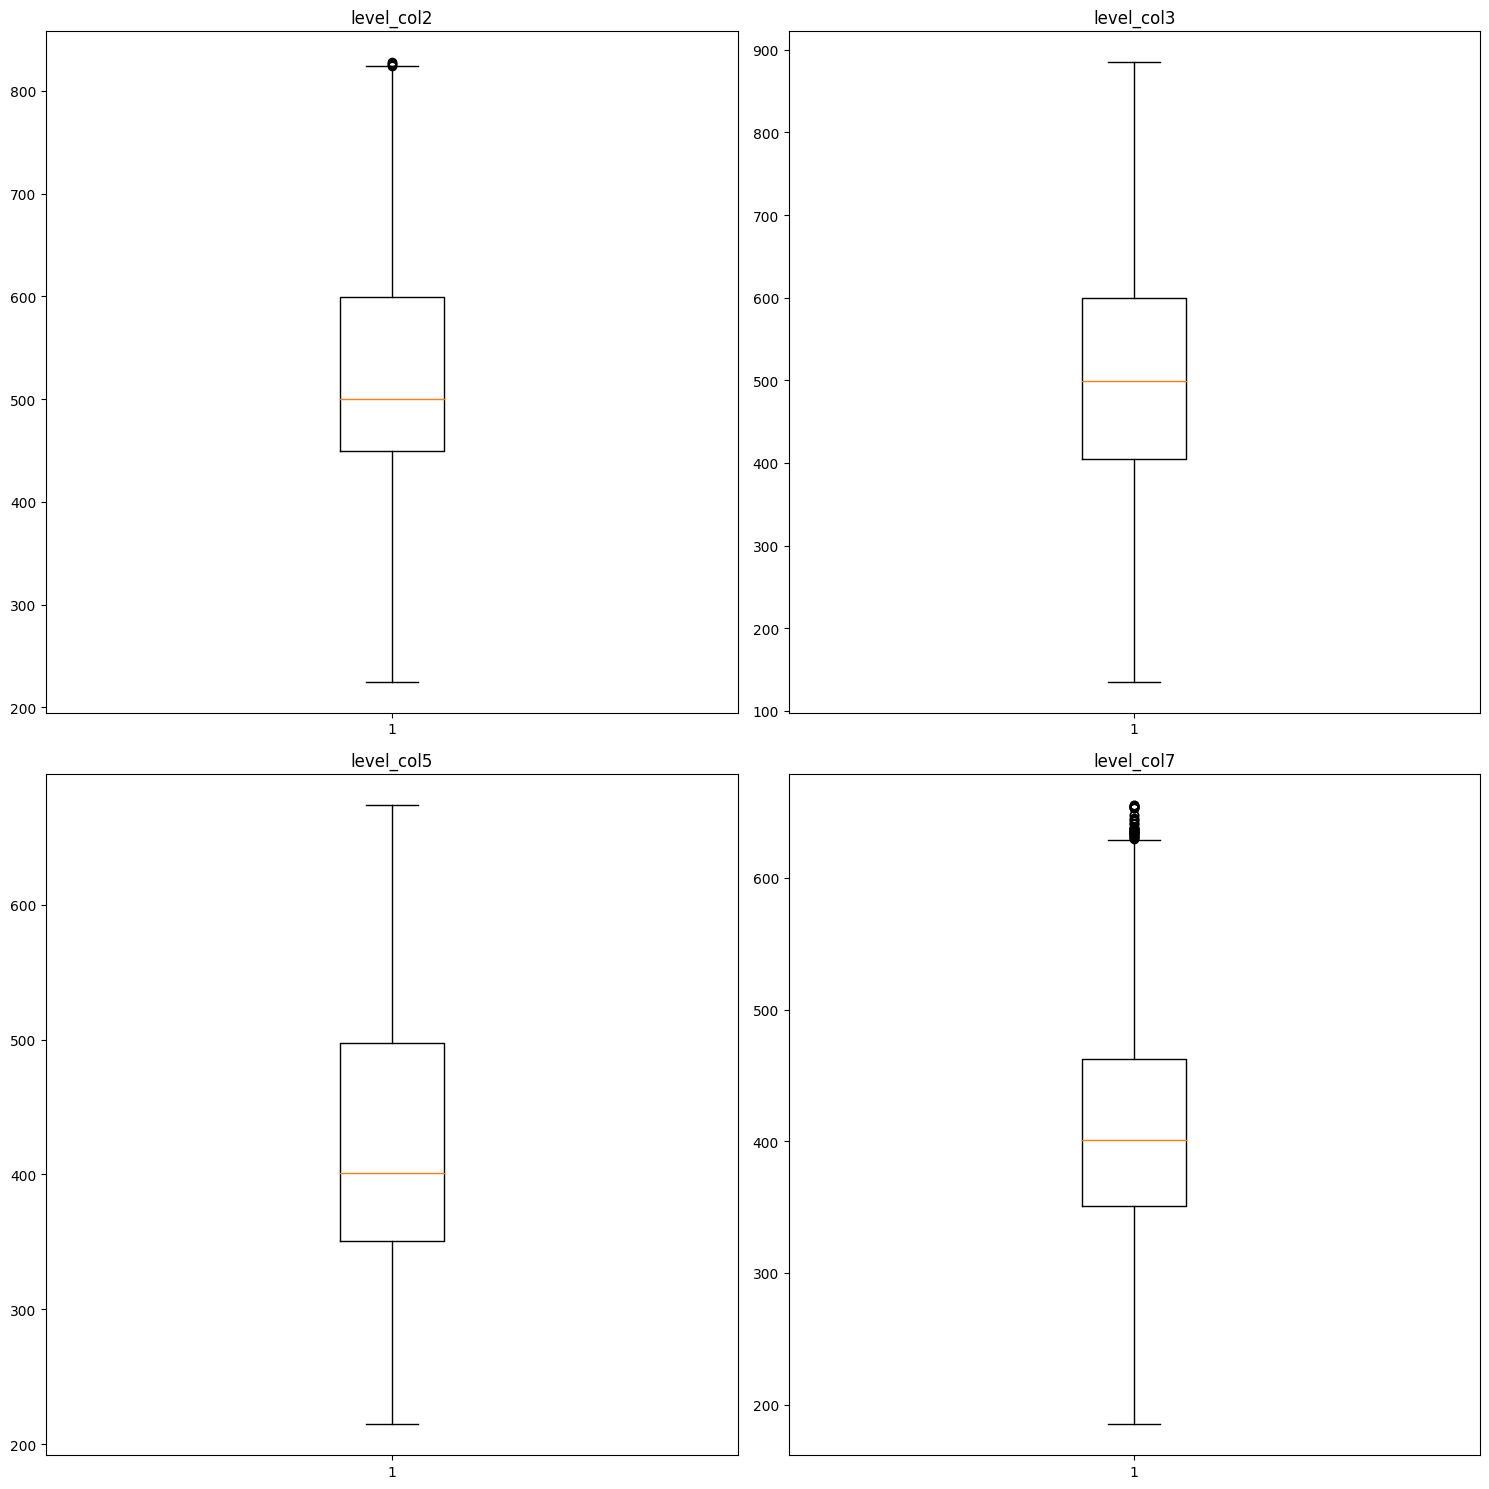

In [187]:
variables = ["level_col2", "level_col3", 
             "level_col5", "level_col7"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, variable in enumerate(variables):
    plt.subplot(2, 2, i+1)
    data = flotation[variable]
    plt.boxplot(data)
    plt.title(variable)

plt.tight_layout()
plt.show()

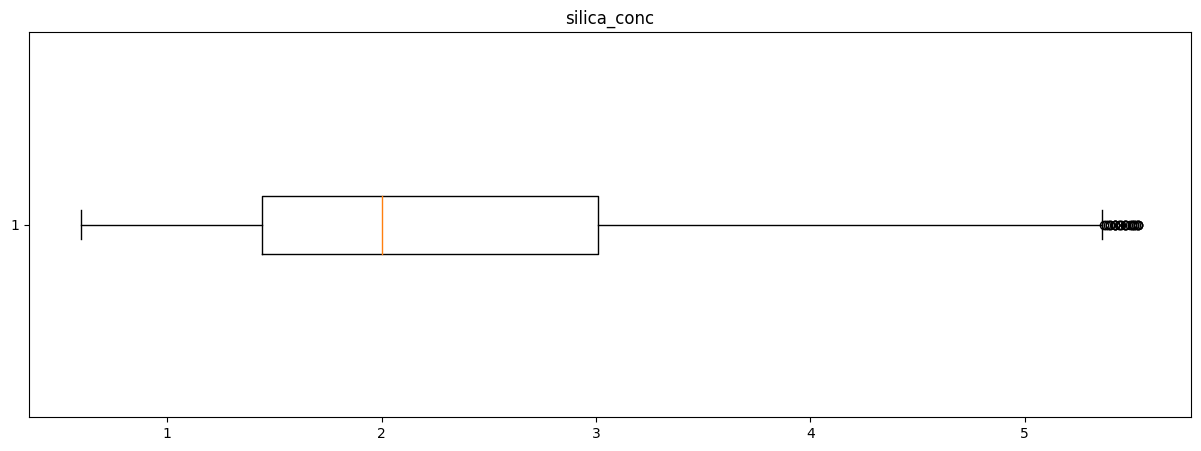

In [193]:
data = flotation["silica_conc"]
plt.figure(figsize=(15, 5))
plt.boxplot(data, vert=False)
plt.title("silica_conc")

plt.show()

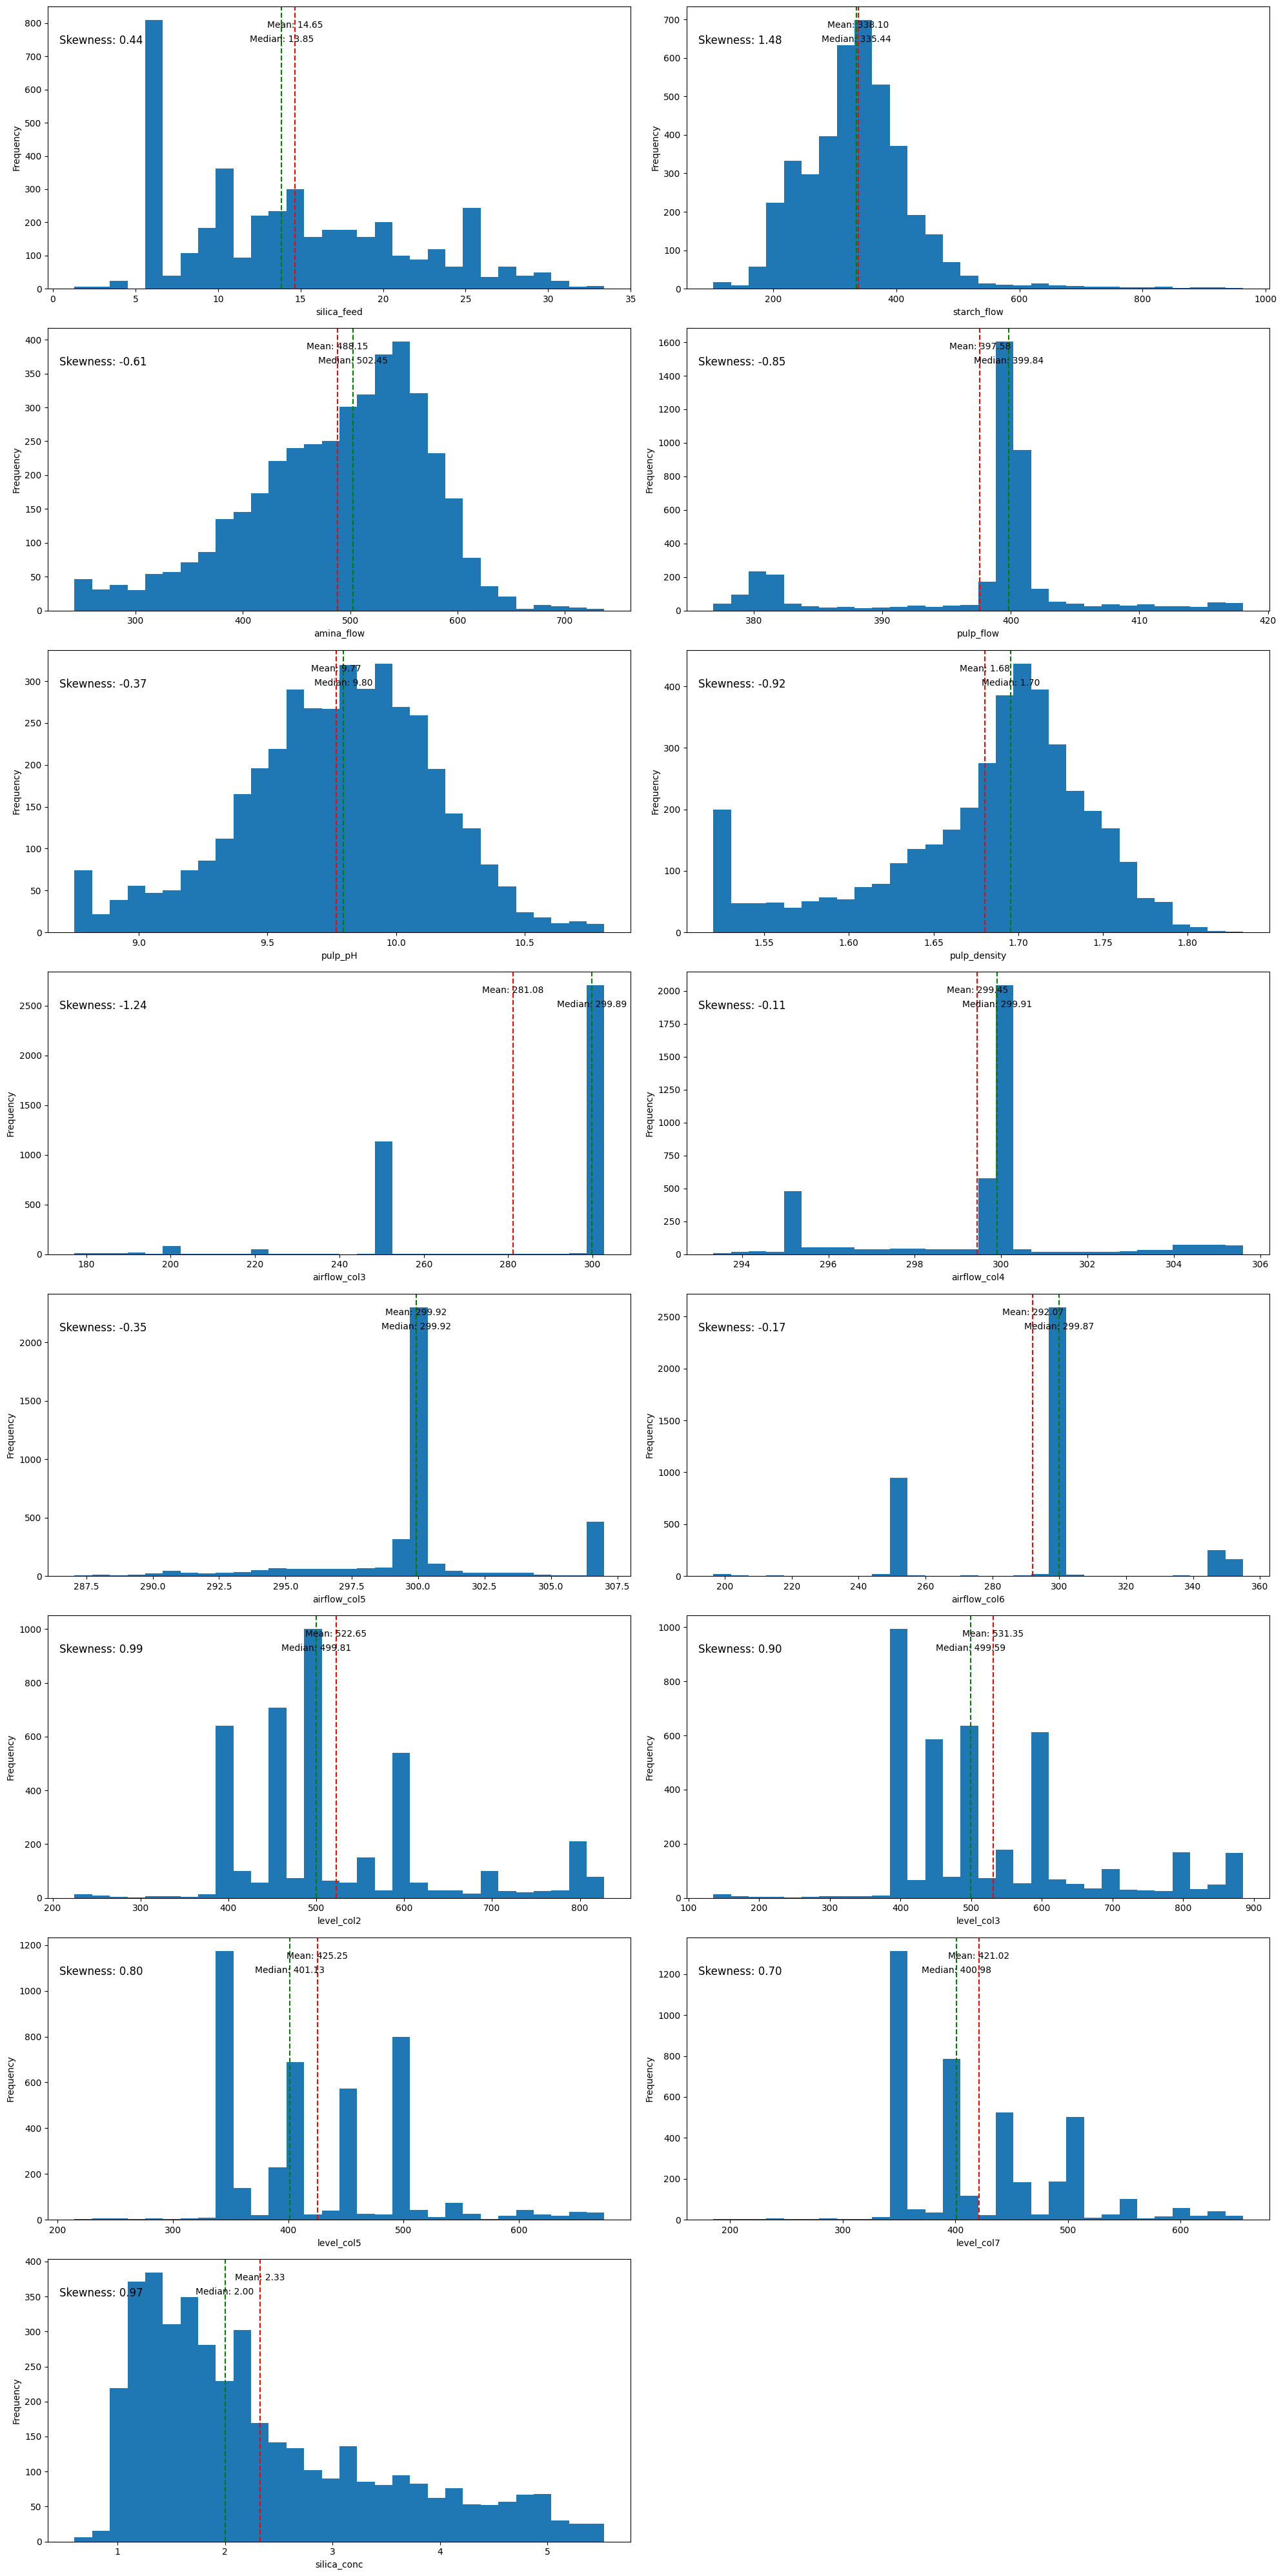

In [194]:
from scipy.stats import skew

variables = ["silica_feed", "starch_flow", "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
             "airflow_col3", "airflow_col4", "airflow_col5", "airflow_col6",
             "level_col2", "level_col3", "level_col5",  "level_col7", "silica_conc"]

num_vars = len(variables)
num_rows = (num_vars + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

for i, variable in enumerate(variables):
    # Select a specific column for skewness calculation
    data = flotation[variable].to_numpy()
    # Calculate the skewness degree
    skewness = skew(data)
    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plotting the variable in the corresponding subplot
    axes[row, col].hist(data, bins=30)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel("Frequency")
    axes[row, col].axvline(np.mean(data), color='r', linestyle='--')
    axes[row, col].axvline(np.median(data), color='g', linestyle='--')
    # Display the skewness degree in the plot frame
    axes[row, col].text(0.02, 0.9, f"Skewness: {skewness:.2f}",
                        transform=axes[row, col].transAxes, 
                        fontsize=12, verticalalignment='top')
    # Display the mean and median values near the lines
    ylim = axes[row, col].get_ylim()
    y_range = ylim[1] - ylim[0]
    axes[row, col].text(np.mean(data), ylim[1] - 0.05 * y_range,
                        f"Mean: {np.mean(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
    axes[row, col].text(np.median(data), ylim[1] - 0.1 * y_range,
                        f"Median: {np.median(data):.2f}", color='black', fontsize=10,
                        verticalalignment='top', horizontalalignment='center')
# Hide empty subplots
if num_vars % 2 != 0:
    axes[num_rows - 1, 1].axis('off')
plt.tight_layout()
plt.show()